In [33]:
# ============================================================================
# SECTION 0: IMPORTS + PLOTTING SETTINGS + PARAMETERS
# ============================================================================

import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Model parameters
RISK_FREE_RATE = 0.04
DIVIDEND_YIELD = 0.0

# Data loading
df = pd.read_csv('./../../../data/raw/tsla_options_with_underlying.csv')
print(f"Data loaded: {len(df)} rows")


Data loaded: 5269839 rows


In [34]:
# ============================================================================
# SECTION 1: DATA NORMALIZATION & VALIDATION
# ============================================================================

print("Original columns:", df.columns.tolist())
print(f"Initial shape: {df.shape}")

# Parse ticker to extract expiry date
def parse_ticker(ticker_str):
    """Parse ticker format: O:TSLA140606C00135000 or O:TSLA1140606C00135000"""
    if pd.isna(ticker_str) or not isinstance(ticker_str, str):
        return None, None
    
    ticker_clean = ticker_str.replace('O:', '')
    import re
    match = re.search(r'(\d+)', ticker_clean)
    if not match:
        return None, None
    
    ticker_symbol = ticker_clean[:match.start()]
    rest = ticker_clean[match.start():]
    
    # Remove trailing "1" from ticker if present
    if ticker_symbol.endswith('1') and len(ticker_symbol) > 1:
        ticker_symbol = ticker_symbol[:-1]
    
    # Extract date: if 7 digits and first is 1, remove it
    if len(rest) >= 7 and rest[0] == '1':
        date_str = rest[1:7]
    elif len(rest) >= 6:
        date_str = rest[0:6]
    else:
        return None, None
    
    # Parse YYMMDD
    try:
        year = 2000 + int(date_str[0:2]) if int(date_str[0:2]) < 50 else 1900 + int(date_str[0:2])
        month = int(date_str[2:4])
        day = int(date_str[4:6])
        expiry_date = pd.Timestamp(year, month, day)
    except:
        return None, None
    
    return ticker_symbol, expiry_date

# Parse tickers
print("\nParsing tickers...")
ticker_info = df['ticker'].apply(parse_ticker)
df['expiry_from_ticker'] = ticker_info.apply(lambda x: x[1] if x[1] is not None else None)

# Use expiry_from_ticker if expiry column is missing/invalid
if 'expiry' not in df.columns or df['expiry'].isna().any():
    df['expiry'] = df['expiry_from_ticker']
else:
    df['expiry'] = df['expiry'].fillna(df['expiry_from_ticker'])

print(f"Parsed {df['expiry_from_ticker'].notna().sum()} / {len(df)} tickers")

# Parse date columns
date_cols = ['date', 'dt', 'expiry', 'window_start']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Normalize date and expiry (removes timezone, sets to midnight)
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.normalize()
df['expiry'] = pd.to_datetime(df['expiry'], errors='coerce').dt.normalize()

# Clean cp column
df['cp'] = df['cp'].astype(str).str.upper().str.strip()

# Compute dte and tte
df['dte'] = (df['expiry'] - df['date']).dt.days
df['tte'] = df['dte'] / 365.0

# Remove invalid rows
initial_count = len(df)
df = df[
    (df['close'] > 0) &
    (df['strike'] > 0) &
    (df['dte'] > 0) &
    (df['tte'] > 0) &
    (df['underlying_price'] > 0) &
    (df['date'].notna()) &
    (df['expiry'].notna())
].copy()

print(f"Removed {initial_count - len(df)} invalid rows ({(initial_count - len(df))/initial_count*100:.1f}%)")
print(f"Final shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Call/Put: {df['cp'].value_counts().to_dict()}")


Original columns: ['Unnamed: 0', 'ticker', 'volume', 'open', 'close', 'high', 'low', 'window_start', 'transactions', 'dt', 'date', 'underlying', 'expiry', 'cp', 'strike', 'dte', 'moneyness', 'underlying_price', 'tte', 'log_moneyness']
Initial shape: (5269839, 20)

Parsing tickers...
Parsed 4220276 / 5269839 tickers
Removed 88858 invalid rows (1.7%)
Final shape: (5180981, 21)
Date range: 2014-06-02 00:00:00 to 2025-12-12 00:00:00
Call/Put: {'C': 2740862, 'P': 2440119}


In [35]:
# ============================================================================
# SECTION 2: SPLIT-AWARE UNADJUSTMENT
# ============================================================================

KNOWN_SPLITS = {'2020-08-31': 5.0, '2022-08-25': 3.0}

def detect_splits_from_options(df, tolerance=0.05):
    """Detect splits from median moneyness ratios."""
    atm_df = df[
        (df['log_moneyness'].abs() <= 0.05) &
        (df['dte'].between(20, 60))
    ].copy()
    
    moneyness_ratios = atm_df.groupby('date').apply(
        lambda x: (x['strike'] / x['underlying_price']).median()
    ).to_frame('median_ratio').sort_index()
    
    detected_splits = {}
    ratios = [2.0, 3.0, 5.0, 1/2, 1/3, 1/5]
    
    for i in range(1, len(moneyness_ratios)):
        prev_ratio = moneyness_ratios.iloc[i-1]['median_ratio']
        curr_ratio = moneyness_ratios.iloc[i]['median_ratio']
        if prev_ratio > 0 and curr_ratio > 0:
            jump = curr_ratio / prev_ratio
            for r in ratios:
                if abs(jump - r) < tolerance * r:
                    detected_splits[moneyness_ratios.index[i]] = r
                    break
    
    return detected_splits, moneyness_ratios

# Detect splits
detected_splits, moneyness_ratios = detect_splits_from_options(df)

# Build final split dict (use detected, fallback to known)
final_splits = detected_splits.copy()
for known_date_str, known_ratio in KNOWN_SPLITS.items():
    known_date = pd.to_datetime(known_date_str)
    has_match = any(abs((pd.to_datetime(d) - known_date).days) <= 3 for d in final_splits.keys())
    if not has_match:
        final_splits[known_date] = known_ratio

print(f"Detected splits: {len(detected_splits)}")
print(f"Final split dates: {sorted([d.date() for d in final_splits.keys()])}")

# Build adjustment factor
unique_dates = pd.to_datetime(sorted(df['date'].unique())).tolist()
adjustment_factors = pd.Series(index=unique_dates, dtype=float)
adjustment_factors.iloc[-1] = 1.0

for i in range(len(unique_dates) - 2, -1, -1):
    curr_date = pd.to_datetime(unique_dates[i + 1])
    prev_date = pd.to_datetime(unique_dates[i])
    split_ratio = None
    for split_date, ratio in final_splits.items():
        split_date_ts = pd.to_datetime(split_date)
        if prev_date < split_date_ts <= curr_date:
            split_ratio = ratio
            break
    adjustment_factors.iloc[i] = adjustment_factors.iloc[i+1] * (split_ratio if split_ratio else 1.0)

# Create underlying dataframe
underlying_df = pd.DataFrame(index=pd.to_datetime(unique_dates))
underlying_df['underlying_price_adj'] = df.groupby('date')['underlying_price'].agg(['median', 'first']).iloc[:, 0]
underlying_df['adjustment_factor'] = adjustment_factors
underlying_df['S_unadj'] = underlying_df['underlying_price_adj'] * underlying_df['adjustment_factor']
underlying_df['split_flag'] = False
for split_date in final_splits.keys():
    if pd.to_datetime(split_date) in underlying_df.index:
        underlying_df.loc[pd.to_datetime(split_date), 'split_flag'] = True

# Merge back
df = df.merge(underlying_df[['S_unadj']], left_on='date', right_index=True, how='left')

# Compute log moneyness using unadjusted price
df['log_moneyness'] = np.log(df['strike'] / df['S_unadj'])

print(f"\nUnadjustment complete:")
print(f"  Adjustment factor range: {underlying_df['adjustment_factor'].min():.2f} to {underlying_df['adjustment_factor'].max():.2f}")
print(f"  S_unadj range: ${underlying_df['S_unadj'].min():.2f} to ${underlying_df['S_unadj'].max():.2f}")


Detected splits: 0
Final split dates: [datetime.date(2020, 8, 31), datetime.date(2022, 8, 25)]

Unadjustment complete:
  Adjustment factor range: 1.00 to 15.00
  S_unadj range: $108.10 to $2238.75


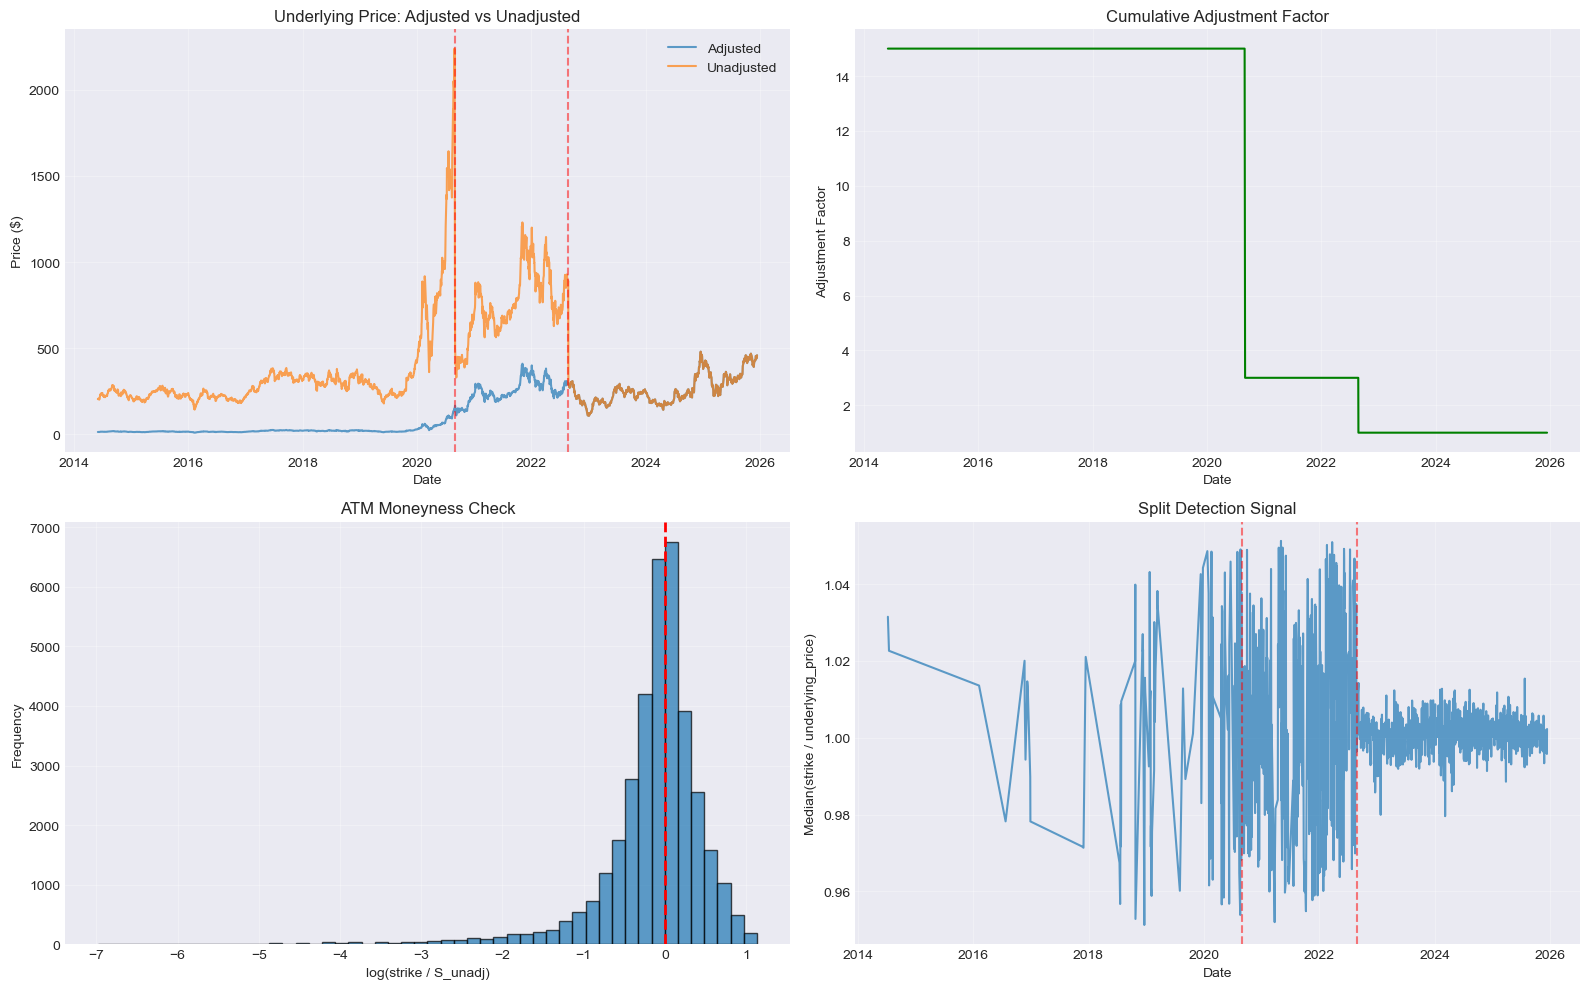


✓ ATM log moneyness median: 0.0001 (should be ~0)


In [36]:
# Validation plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

ax = axes[0, 0]
ax.plot(underlying_df.index, underlying_df['underlying_price_adj'], label='Adjusted', alpha=0.7)
ax.plot(underlying_df.index, underlying_df['S_unadj'], label='Unadjusted', alpha=0.7)
for sd in underlying_df[underlying_df['split_flag']].index:
    ax.axvline(sd, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('Underlying Price: Adjusted vs Unadjusted')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(underlying_df.index, underlying_df['adjustment_factor'], color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Adjustment Factor')
ax.set_title('Cumulative Adjustment Factor')
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
sample_dates = np.random.choice(unique_dates, min(20, len(unique_dates)), replace=False)
all_log_mny = []
for date in sample_dates:
    date_data = df[df['date'] == date]
    if len(date_data) > 0:
        log_mny = np.log(date_data['strike'] / date_data['S_unadj'])
        all_log_mny.extend(log_mny.dropna().tolist())
ax.hist(all_log_mny, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('log(strike / S_unadj)')
ax.set_ylabel('Frequency')
ax.set_title('ATM Moneyness Check')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
moneyness_ratios.index = pd.to_datetime(moneyness_ratios.index)
ax.plot(moneyness_ratios.index, moneyness_ratios['median_ratio'], alpha=0.7)
for sd in underlying_df[underlying_df['split_flag']].index:
    ax.axvline(sd, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Median(strike / underlying_price)')
ax.set_title('Split Detection Signal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./unadjustment_validation.png', dpi=150, bbox_inches='tight')
plt.show()

# Sanity checks
atm_data = df[(df['log_moneyness'].abs() <= 0.05) & (df['dte'].between(20, 60))]
if len(atm_data) > 0:
    log_mny_check = np.log(atm_data['strike'] / atm_data['S_unadj'])
    median_log_mny = log_mny_check.median()
    print(f"\n✓ ATM log moneyness median: {median_log_mny:.4f} (should be ~0)")
    if abs(median_log_mny) > 0.1:
        raise ValueError(f"ATM moneyness not centered! Median={median_log_mny:.4f}")


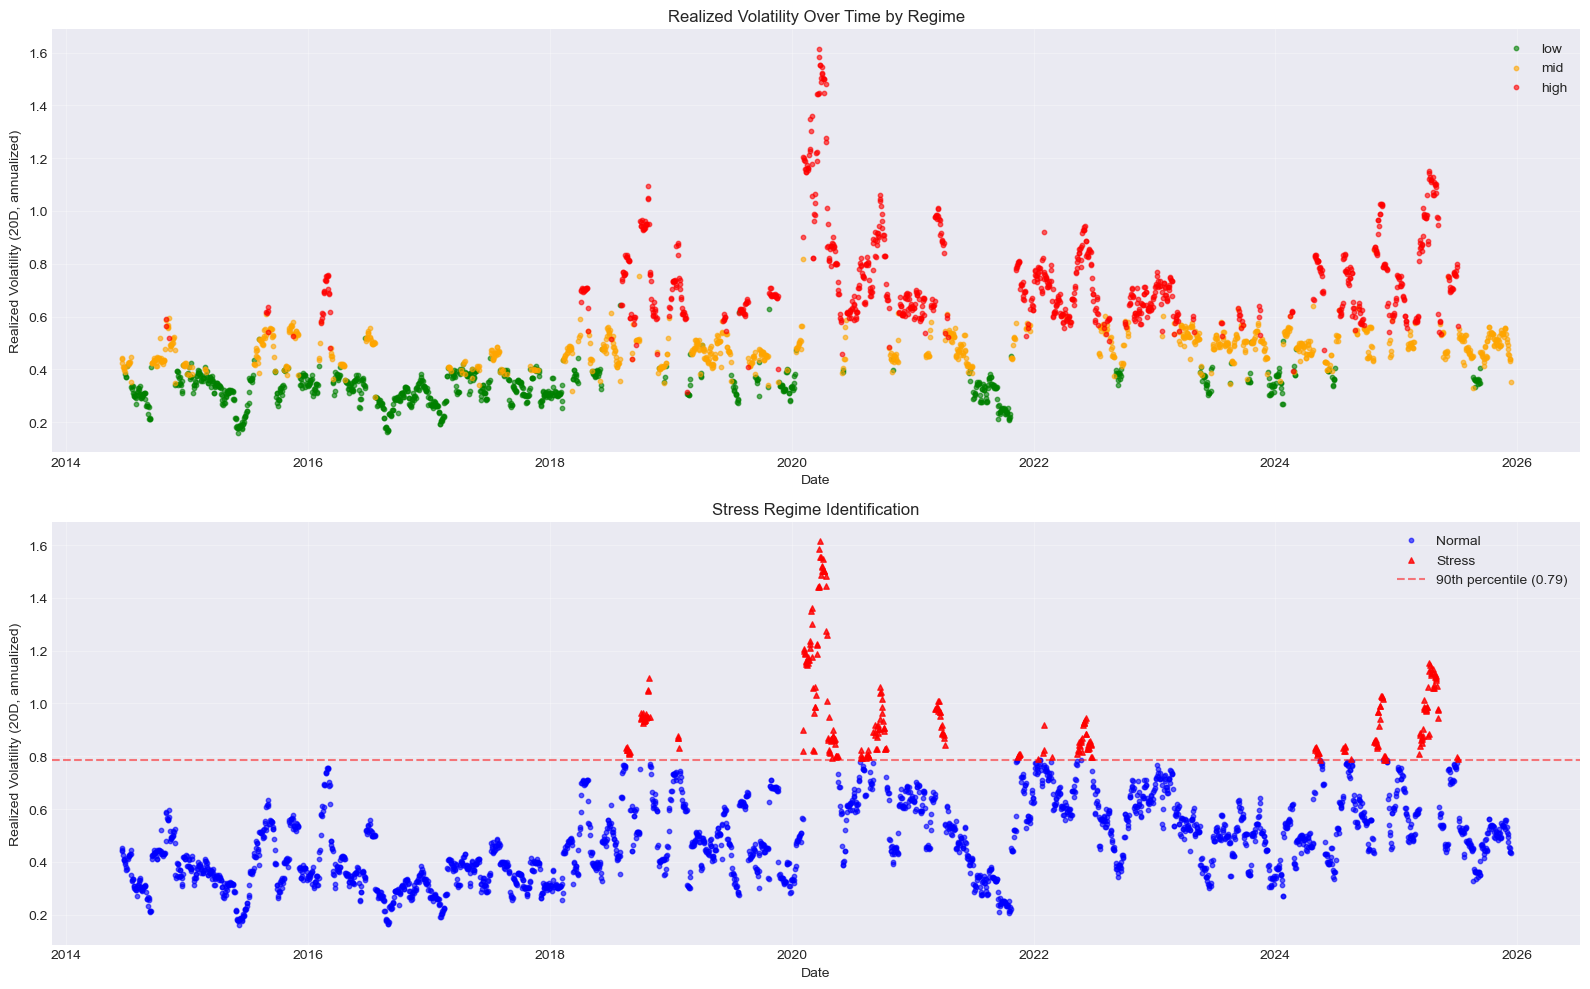


RV_20 quantiles: 33rd=0.3980, 67th=0.5695, 90th=0.7864
Regime distribution:
regime
mid        982
low        955
high       955
unknown     11
Name: count, dtype: int64

=== SANITY CHECK: Top 10 Dates by RV_20 ===
               RV_20     S_unadj  is_near_split
2020-03-25  1.614869  539.250015          False
2020-03-24  1.584137  505.000020          False
2020-03-27  1.553759  514.360020          False
2020-03-26  1.553015  528.160005          False
2020-04-03  1.547025  480.010020          False
2020-04-02  1.522435  454.470000          False
2020-04-01  1.517578  481.560000          False
2020-04-06  1.503481  516.240000          False
2020-03-31  1.502047  524.000010          False
2020-04-08  1.501314  548.839995          False

Dates near splits: 0 / 10


In [37]:
# ============================================================================
# SECTION 3: REALIZED VOLATILITY + REGIME LABELS
# ============================================================================

underlying_df = underlying_df.sort_index()

# Compute log returns using S_unadj only
underlying_df['log_return'] = np.log(underlying_df['S_unadj'] / underlying_df['S_unadj'].shift(1))

# Identify dates to exclude (splits and gaps)
exclude_mask = pd.Series(False, index=underlying_df.index)

# Mark split dates and ±1 trading day around each split
if 'final_splits' in locals() and len(final_splits) > 0:
    split_dates = [pd.to_datetime(d) for d in final_splits.keys()]
    for split_date in split_dates:
        # Find the trading date closest to split_date
        closest_idx = underlying_df.index.get_indexer([split_date], method='nearest')[0]
        if closest_idx >= 0:
            split_trading_date = underlying_df.index[closest_idx]
            # Mark split date and ±1 trading day
            date_idx = underlying_df.index.get_loc(split_trading_date)
            for offset in [-1, 0, 1]:
                if 0 <= date_idx + offset < len(underlying_df):
                    exclude_mask.iloc[date_idx + offset] = True

# Mark dates with calendar gaps > 3 days
for i in range(1, len(underlying_df)):
    curr_date = underlying_df.index[i]
    prev_date = underlying_df.index[i-1]
    calendar_gap = (curr_date - prev_date).days
    if calendar_gap > 3:
        exclude_mask.iloc[i] = True

# Set log returns to NaN on excluded dates
underlying_df.loc[exclude_mask, 'log_return'] = np.nan

# Optionally clip extreme returns (abs(ret) > 0.5) to NaN for robustness
extreme_mask = underlying_df['log_return'].abs() > 0.5
underlying_df.loc[extreme_mask, 'log_return'] = np.nan

# Compute RV_20 as 20-day rolling std of cleaned log returns, annualized
underlying_df['RV_20'] = underlying_df['log_return'].rolling(window=20, min_periods=10).std() * np.sqrt(252)
underlying_df['RV_20_lag1'] = underlying_df['RV_20'].shift(1)

# Compute quantiles on lagged RV
rv_20_lag1_valid = underlying_df['RV_20_lag1'].dropna()
q33 = rv_20_lag1_valid.quantile(0.33)
q67 = rv_20_lag1_valid.quantile(0.67)
q90 = rv_20_lag1_valid.quantile(0.90)

def assign_regime(rv):
    if pd.isna(rv):
        return 'unknown'
    elif rv <= q33:
        return 'low'
    elif rv <= q67:
        return 'mid'
    else:
        return 'high'

def assign_stress_regime(rv):
    if pd.isna(rv):
        return 'normal'
    elif rv >= q90:
        return 'stress'
    else:
        return 'normal'

# Assign regime based on lagged RV
underlying_df['regime'] = underlying_df['RV_20_lag1'].apply(assign_regime)
underlying_df['stress_regime'] = underlying_df['RV_20_lag1'].apply(assign_stress_regime)

# Merge both RV_20 (for display) and RV_20_lag1 (for regime assignment)
df = df.merge(underlying_df[['RV_20', 'RV_20_lag1', 'regime', 'stress_regime']], left_on='date', right_index=True, how='left')

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
ax = axes[0]
for regime_name, color in [('low', 'green'), ('mid', 'orange'), ('high', 'red')]:
    mask = underlying_df['regime'] == regime_name
    ax.scatter(underlying_df.index[mask], underlying_df['RV_20'][mask], label=regime_name, alpha=0.6, s=10, color=color)
ax.set_xlabel('Date')
ax.set_ylabel('Realized Volatility (20D, annualized)')
ax.set_title('Realized Volatility Over Time by Regime')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
normal_mask = underlying_df['stress_regime'] == 'normal'
stress_mask = underlying_df['stress_regime'] == 'stress'
ax.scatter(underlying_df.index[normal_mask], underlying_df['RV_20_lag1'][normal_mask], label='Normal', alpha=0.6, s=10, color='blue')
ax.scatter(underlying_df.index[stress_mask], underlying_df['RV_20_lag1'][stress_mask], label='Stress', alpha=0.8, s=15, color='red', marker='^')
ax.axhline(q90, color='red', linestyle='--', alpha=0.5, label=f'90th percentile ({q90:.2f})')
ax.set_xlabel('Date')
ax.set_ylabel('Realized Volatility (20D, annualized)')
ax.set_title('Stress Regime Identification')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./rv_regimes.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nRV_20 quantiles: 33rd={q33:.4f}, 67th={q67:.4f}, 90th={q90:.4f}")
print(f"Regime distribution:\n{underlying_df['regime'].value_counts()}")

# Sanity check: Top 10 dates by RV_20
print("\n=== SANITY CHECK: Top 10 Dates by RV_20 ===")
top_rv = underlying_df.nlargest(10, 'RV_20')[['RV_20', 'S_unadj']].copy()
top_rv['is_near_split'] = False

if 'final_splits' in locals() and len(final_splits) > 0:
    split_dates = [pd.to_datetime(d) for d in final_splits.keys()]
    for idx in top_rv.index:
        for split_date in split_dates:
            closest_idx = underlying_df.index.get_indexer([split_date], method='nearest')[0]
            if closest_idx >= 0:
                split_trading_date = underlying_df.index[closest_idx]
                days_diff = abs((idx - split_trading_date).days)
                if days_diff <= 1:
                    top_rv.loc[idx, 'is_near_split'] = True
                    break

print(top_rv.to_string())
print(f"\nDates near splits: {top_rv['is_near_split'].sum()} / {len(top_rv)}")

In [38]:
# ============================================================================
# SECTION 4: BLACK-SCHOLES FUNCTIONS (VECTORIZED)
# ============================================================================

# Use working scalar BS price function from user's code, vectorized
def _bs_price_scalar(S: float, K: float, T: float, r: float, q: float, sigma: float, is_call: bool) -> float:
    """Black–Scholes price for a call or put (scalar, using math functions like user's working code)."""
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan

    sqrtT = math.sqrt(T)
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma * sigma) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT

    if is_call:
        return S * math.exp(-q * T) * _norm_cdf(d1) - K * math.exp(-r * T) * _norm_cdf(d2)
    else:
        return K * math.exp(-r * T) * _norm_cdf(-d2) - S * math.exp(-q * T) * _norm_cdf(-d1)

def black_scholes_price_vec(S, K, T, r, sigma, q=0.0, is_call=True):
    """Vectorized Black-Scholes option pricing using working scalar function."""
    # Convert to arrays
    S = np.asarray(S)
    K = np.asarray(K)
    T = np.asarray(T)
    sigma = np.asarray(sigma)
    
    # Check if inputs are scalars
    is_scalar = S.ndim == 0
    
    # Convert to 1D arrays for processing
    if is_scalar:
        S = np.array([S])
        K = np.array([K])
        T = np.array([T])
        sigma = np.array([sigma])
    
    # Convert is_call to array
    if isinstance(is_call, bool):
        is_call = np.full(len(S), is_call, dtype=bool)
    else:
        is_call = np.asarray(is_call)
        if is_call.ndim == 0:
            is_call = np.array([is_call])
    
    # Vectorize the scalar function
    price = np.array([
        _bs_price_scalar(float(s), float(k), float(t), r, q, float(sig), bool(ic))
        for s, k, t, sig, ic in zip(S, K, T, sigma, is_call)
    ])
    
    return float(price[0]) if is_scalar else price

# Use working scalar delta function, vectorized
def _bs_delta_scalar(S: float, K: float, T: float, r: float, q: float, sigma: float, is_call: bool) -> float:
    """Black–Scholes delta (scalar, using math functions like user's working code)."""
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan

    sqrtT = math.sqrt(T)
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma * sigma) * T) / (sigma * sqrtT)

    disc_q = math.exp(-q * T)
    if is_call:
        return disc_q * _norm_cdf(d1)
    else:
        return -disc_q * _norm_cdf(-d1)

def black_scholes_delta_vec(S, K, T, r, sigma, q=0.0, is_call=True):
    """Vectorized Black-Scholes delta using working scalar function."""
    # Convert to arrays
    S = np.asarray(S)
    K = np.asarray(K)
    T = np.asarray(T)
    sigma = np.asarray(sigma)
    
    # Check if inputs are scalars
    is_scalar = S.ndim == 0
    
    # Convert to 1D arrays for processing
    if is_scalar:
        S = np.array([S])
        K = np.array([K])
        T = np.array([T])
        sigma = np.array([sigma])
    
    # Convert is_call to array
    if isinstance(is_call, bool):
        is_call = np.full(len(S), is_call, dtype=bool)
    else:
        is_call = np.asarray(is_call)
        if is_call.ndim == 0:
            is_call = np.array([is_call])
    
    # Fix 3: Use explicit indices instead of chained indexing
    # Vectorize the scalar function (this is safe, but keeping for consistency)
    delta = np.array([
        _bs_delta_scalar(float(s), float(k), float(t), r, q, float(sig), bool(ic))
        for s, k, t, sig, ic in zip(S, K, T, sigma, is_call)
    ])
    
    return float(delta[0]) if is_scalar else delta

# Use working scalar gamma function, vectorized
def _bs_gamma_scalar(S: float, K: float, T: float, r: float, q: float, sigma: float) -> float:
    """Black–Scholes gamma (scalar, using math functions like user's working code)."""
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan

    sqrtT = math.sqrt(T)
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma * sigma) * T) / (sigma * sqrtT)

    disc_q = math.exp(-q * T)
    pdf_d1 = _norm_pdf(d1)
    return disc_q * pdf_d1 / (S * sigma * sqrtT)

def black_scholes_gamma_vec(S, K, T, r, sigma, q=0.0):
    """Vectorized Black-Scholes gamma using working scalar function."""
    # Convert to arrays
    S = np.asarray(S)
    K = np.asarray(K)
    T = np.asarray(T)
    sigma = np.asarray(sigma)
    
    # Check if inputs are scalars
    is_scalar = S.ndim == 0
    
    # Convert to 1D arrays for processing
    if is_scalar:
        S = np.array([S])
        K = np.array([K])
        T = np.array([T])
        sigma = np.array([sigma])
    
    # Vectorize the scalar function
    gamma = np.array([
        _bs_gamma_scalar(float(s), float(k), float(t), r, q, float(sig))
        for s, k, t, sig in zip(S, K, T, sigma)
    ])
    
    return float(gamma[0]) if is_scalar else gamma

# Use working bisection method from user's code
import math

def _norm_cdf(x: float) -> float:
    """Standard normal CDF using math.erf."""
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def _norm_pdf(x: float) -> float:
    """Standard normal PDF."""
    return math.exp(-0.5 * x * x) / math.sqrt(2.0 * math.pi)

def _bs_price_scalar(S: float, K: float, T: float, r: float, q: float, sigma: float, is_call: bool) -> float:
    """Black–Scholes price for a call or put (scalar version)."""
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan

    sqrtT = math.sqrt(T)
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma * sigma) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT

    if is_call:
        return S * math.exp(-q * T) * _norm_cdf(d1) - K * math.exp(-r * T) * _norm_cdf(d2)
    else:
        return K * math.exp(-r * T) * _norm_cdf(-d2) - S * math.exp(-q * T) * _norm_cdf(-d1)

def implied_volatility(market_price, S, K, T, r, q=0.0, option_type='C', sigma_min=1e-6, sigma_max=5.0, tol=1e-6, max_iter=100):
    """
    Implied vol via bisection (using working method from user's code).
    Returns np.nan if no solution.
    """
    # Convert to floats
    market_price = float(market_price)
    S = float(S)
    K = float(K)
    T = float(T)
    option_type = str(option_type).upper().strip()
    is_call = (option_type == 'C')
    
    if T <= 0 or S <= 0 or K <= 0 or market_price <= 0:
        return np.nan

    price_low = _bs_price_scalar(S, K, T, r, q, sigma_min, is_call)
    price_high = _bs_price_scalar(S, K, T, r, q, sigma_max, is_call)

    # If market price outside attainable range, bail
    if not (np.isfinite(price_low) and np.isfinite(price_high)):
        return np.nan
    if not (price_low <= market_price <= price_high):
        return np.nan

    lo, hi = sigma_min, sigma_max
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        price_mid = _bs_price_scalar(S, K, T, r, q, mid, is_call)
        if not np.isfinite(price_mid):
            return np.nan

        if abs(price_mid - market_price) < tol:
            return mid

        if price_mid > market_price:
            hi = mid
        else:
            lo = mid

    return 0.5 * (lo + hi)

# Vectorized IV computation using batch processing (using working bisection method)
def compute_iv_vectorized(market_prices, S, K, T, r, q, option_types, sigma_min=1e-6, sigma_max=5.0):
    """Compute IV for arrays using bisection method."""
    market_prices = np.asarray(market_prices)
    S = np.asarray(S)
    K = np.asarray(K)
    T = np.asarray(T)
    # Keep option_types as pandas Series or list to preserve string type
    if isinstance(option_types, pd.Series):
        option_types = option_types.values
    else:
        option_types = np.asarray(option_types)
    
    iv_results = np.full(len(market_prices), np.nan, dtype=float)
    
    # Process in batches to avoid memory issues
    batch_size = 10000
    total_batches = (len(market_prices) + batch_size - 1) // batch_size
    
    computed_count = 0
    failed_count = 0
    invalid_input_count = 0
    
    for i in tqdm(range(0, len(market_prices), batch_size), desc="Computing IV", total=total_batches):
        end_idx = min(i + batch_size, len(market_prices))
        batch_prices = market_prices[i:end_idx]
        batch_S = S[i:end_idx]
        batch_K = K[i:end_idx]
        batch_T = T[i:end_idx]
        batch_cp = option_types[i:end_idx]
        
        for j in range(len(batch_prices)):
            mp = float(batch_prices[j])
            s = float(batch_S[j])
            k = float(batch_K[j])
            t = float(batch_T[j])
            cp = str(batch_cp[j]).upper().strip()
            
            # Validate inputs
            if mp > 0 and t > 0 and s > 0 and k > 0 and cp in ['C', 'P']:
                try:
                    iv_val = implied_volatility(
                        mp, s, k, t,
                        r, q, cp, sigma_min, sigma_max
                    )
                    if np.isfinite(iv_val) and iv_val > 0:
                        iv_results[i+j] = iv_val
                        computed_count += 1
                    else:
                        failed_count += 1
                except Exception as e:
                    failed_count += 1
            else:
                invalid_input_count += 1
    
    print(f"Computed {computed_count:,} valid IVs out of {len(market_prices):,} total")
    print(f"  Failed: {failed_count:,}, Invalid inputs: {invalid_input_count:,}")
    return iv_results

print("Black-Scholes functions defined (vectorized).")


Black-Scholes functions defined (vectorized).


In [39]:
# ============================================================================
# SECTION 5: COMPUTE IMPLIED VOLS + GREEKS (VECTORIZED)
# ============================================================================

print("Computing implied volatilities and Greeks (vectorized)...")
print(f"Processing {len(df)} option-day observations...")

# Cache IV computation to avoid recomputing
import os
import hashlib
cache_dir = './_cache'
os.makedirs(cache_dir, exist_ok=True)

# Create hash of input data for cache key
input_hash = hashlib.md5(
    pd.concat([
        df['close'].round(4),
        df['S_unadj'].round(2),
        df['strike'].round(2),
        df['tte'].round(6),
        df['cp']
    ], axis=1).values.tobytes()
).hexdigest()[:16]

cache_file = os.path.join(cache_dir, f'iv_cache_{input_hash}.parquet')

# Check if cache exists and is valid
cache_valid = False
if os.path.exists(cache_file):
    print("Loading IV from cache...")
    try:
        cached_iv = pd.read_parquet(cache_file)
        if len(cached_iv) == len(df):
            cached_iv_values = cached_iv['iv'].values
            # Check if cache is valid (not all NaNs)
            valid_count = (~pd.isna(cached_iv_values)).sum()
            if valid_count > 0:
                df['iv'] = cached_iv_values
                print(f"✓ Loaded IV from cache ({valid_count:,} / {len(df):,} valid, {valid_count/len(df)*100:.1f}%)")
                cache_valid = True
            else:
                print("Cache contains all NaNs, recomputing...")
        else:
            print(f"Cache length mismatch ({len(cached_iv)} vs {len(df)}), recomputing...")
    except Exception as e:
        print(f"Error loading cache: {e}, recomputing...")

if not cache_valid:
    # Compute IV (still need iterative solver, but use vectorized batch processing)
    print("Computing implied volatilities (this may take a while)...")
    df['iv'] = compute_iv_vectorized(
        df['close'].values,
        df['S_unadj'].values,
        df['strike'].values,
        df['tte'].values,
        RISK_FREE_RATE,
        DIVIDEND_YIELD,
        df['cp'].values
    )
    # Save to cache
    pd.DataFrame({'iv': df['iv']}).to_parquet(cache_file)
    valid_count = (~pd.isna(df['iv'])).sum()
    print(f"✓ Saved IV to cache ({valid_count:,} / {len(df):,} valid, {valid_count/len(df)*100:.1f}%)")

# Compute delta (fully vectorized)
print("Computing deltas (vectorized)...")
is_call = (df['cp'].str.upper() == 'C').values
df['delta'] = black_scholes_delta_vec(
    df['S_unadj'].values,
    df['strike'].values,
    df['tte'].values,
    RISK_FREE_RATE,
    df['iv'].fillna(0.3).values,
    DIVIDEND_YIELD,
    is_call
)

# Compute gamma (fully vectorized)
print("Computing gammas (vectorized)...")
df['gamma'] = black_scholes_gamma_vec(
    df['S_unadj'].values,
    df['strike'].values,
    df['tte'].values,
    RISK_FREE_RATE,
    df['iv'].fillna(0.3).values,
    DIVIDEND_YIELD
)

iv_valid = df['iv'].dropna()
print(f"\nIV Statistics:")
print(f"  Valid IV: {len(iv_valid)} / {len(df)} ({len(iv_valid)/len(df)*100:.1f}%)")
print(f"  Mean: {iv_valid.mean():.4f}, Median: {iv_valid.median():.4f}")
print(f"  Range: [{iv_valid.min():.4f}, {iv_valid.max():.4f}]")

df['iv_valid'] = df['iv'].between(0.01, 3.0)


Computing implied volatilities and Greeks (vectorized)...
Processing 5180981 option-day observations...
Computing implied volatilities (this may take a while)...


Computing IV: 100%|██████████| 519/519 [02:08<00:00,  4.05it/s]


Computed 4,936,396 valid IVs out of 5,180,981 total
  Failed: 244,585, Invalid inputs: 0
✓ Saved IV to cache (4,936,396 / 5,180,981 valid, 95.3%)
Computing deltas (vectorized)...
Computing gammas (vectorized)...

IV Statistics:
  Valid IV: 4936396 / 5180981 (95.3%)
  Mean: 0.7512, Median: 0.6373
  Range: [0.0258, 4.9996]


In [40]:
df.tail()

,Unnamed: 0,ticker,volume,open,close,high,low,window_start,transactions,dt,...,expiry_from_ticker,S_unadj,RV_20,RV_20_lag1,regime,stress_regime,iv,delta,gamma,iv_valid
5269834,5269834,O:TSLA280616P00660000,4,276.07,277.63,282.19,276.07,2025-12-12 05:00:00,4,2025-12-12 00:00:00-05:00,...,2028-06-16,458.959991,0.350629,0.432375,mid,normal,0.631499,-0.405965,0.000844,True
5269835,5269835,O:TSLA280616P00700000,21,314.30,309.98,314.30,309.98,2025-12-12 05:00:00,3,2025-12-12 00:00:00-05:00,...,2028-06-16,458.959991,0.350629,0.432375,mid,normal,0.645234,-0.421961,0.000834,True
5269836,5269836,O:TSLA280616P00720000,5,324.22,326.81,326.81,324.15,2025-12-12 05:00:00,5,2025-12-12 00:00:00-05:00,...,2028-06-16,458.959991,0.350629,0.432375,mid,normal,0.653525,-0.428481,0.000826,True
5269837,5269837,O:TSLA280616P00780000,5,372.20,372.20,372.20,372.20,2025-12-12 05:00:00,1,2025-12-12 00:00:00-05:00,...,2028-06-16,458.959991,0.350629,0.432375,mid,normal,0.657660,-0.456658,0.000829,True
5269838,5269838,O:TSLA280616P00830000,1,416.90,416.90,416.90,416.90,2025-12-12 05:00:00,1,2025-12-12 00:00:00-05:00,...,2028-06-16,458.959991,0.350629,0.432375,mid,normal,0.682047,-0.465949,0.000801,True


In [41]:
# ============================================================================
# SECTION 6: SIGMA_PROXY + RESIDUALS
# ============================================================================

# Ensure underlying_df exists and has RV_20 (from Section 3)
if 'underlying_df' not in locals() or 'RV_20' not in underlying_df.columns:
    # Recreate underlying_df if needed (should have been created in Section 2 and 3)
    unique_dates = pd.to_datetime(sorted(df['date'].unique()))
    underlying_df = pd.DataFrame(index=unique_dates)
    underlying_df['S_unadj'] = df.groupby('date')['S_unadj'].first()
    underlying_df['log_return'] = np.log(underlying_df['S_unadj'] / underlying_df['S_unadj'].shift(1))
    underlying_df['RV_20'] = underlying_df['log_return'].rolling(window=20, min_periods=10).std() * np.sqrt(252)
    underlying_df['RV_20_lag1'] = underlying_df['RV_20'].shift(1)

# Option 1: Trailing realized vol
underlying_df['sigma_proxy_RV'] = underlying_df['RV_20_lag1']

# Option 2: Cross-sectional ATM IV (median) smoothed
atm_30dte = df[
    (df['iv_valid']) &
    (df['log_moneyness'].abs() <= 0.05) &
    (df['dte'].between(25, 35))
].copy()

if len(atm_30dte) > 0:
    atm_iv_by_date = atm_30dte.groupby('date')['iv'].median()
    underlying_df['sigma_proxy_IV_raw'] = underlying_df.index.map(lambda d: atm_iv_by_date.get(d, np.nan))
    underlying_df['sigma_proxy_IV'] = underlying_df['sigma_proxy_IV_raw'].rolling(window=5, min_periods=1, center=False).median().shift(1)
else:
    underlying_df['sigma_proxy_IV'] = np.nan

# Merge proxies (drop existing columns if they exist to avoid conflicts)
cols_to_drop = ['sigma_proxy_RV', 'sigma_proxy_IV', 'sigma_proxy']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

df = df.merge(underlying_df[['sigma_proxy_RV', 'sigma_proxy_IV']], left_on='date', right_index=True, how='left')
df['sigma_proxy'] = df['sigma_proxy_RV'].fillna(df['sigma_proxy_IV'])

# Debug: Check sigma_proxy
print(f"\nSigma proxy statistics:")
print(f"  sigma_proxy_RV: {df['sigma_proxy_RV'].notna().sum():,} / {len(df):,} valid ({df['sigma_proxy_RV'].notna().sum()/len(df)*100:.1f}%)")
print(f"  sigma_proxy_IV: {df['sigma_proxy_IV'].notna().sum():,} / {len(df):,} valid ({df['sigma_proxy_IV'].notna().sum()/len(df)*100:.1f}%)")
print(f"  sigma_proxy: {df['sigma_proxy'].notna().sum():,} / {len(df):,} valid ({df['sigma_proxy'].notna().sum()/len(df)*100:.1f}%)")
if df['sigma_proxy'].notna().sum() > 0:
    print(f"  sigma_proxy range: [{df['sigma_proxy'].min():.4f}, {df['sigma_proxy'].max():.4f}]")
    print(f"  sigma_proxy mean: {df['sigma_proxy'].mean():.4f}")

# Compute BS model prices using sigma_proxy (vectorized)
print("\nComputing BS model prices (vectorized)...")
is_call = (df['cp'].str.upper() == 'C').values

# Use fillna with a reasonable default (median of valid sigma_proxy or 0.5)
sigma_default = df['sigma_proxy'].median() if df['sigma_proxy'].notna().sum() > 0 else 0.5
if pd.isna(sigma_default) or sigma_default <= 0:
    sigma_default = 0.5

df['bs_price_proxy'] = black_scholes_price_vec(
    df['S_unadj'].values,
    df['strike'].values,
    df['tte'].values,
    RISK_FREE_RATE,
    df['sigma_proxy'].fillna(sigma_default).values,
    DIVIDEND_YIELD,
    is_call
)

# Debug: Check BS prices
print(f"  BS prices computed: {df['bs_price_proxy'].notna().sum():,} / {len(df):,} valid")
if df['bs_price_proxy'].notna().sum() > 0:
    print(f"  BS price range: [${df['bs_price_proxy'].min():.4f}, ${df['bs_price_proxy'].max():.4f}]")

# Compute residuals
df['residual_proxy'] = df['close'] - df['bs_price_proxy']
df['residual_proxy_pct'] = (df['residual_proxy'] / df['close']) * 100

residual_valid = df['residual_proxy'].dropna()
print(f"\nResidual Statistics (using sigma_proxy):")
if len(residual_valid) > 0:
    print(f"  Mean: ${residual_valid.mean():.4f}")
    print(f"  Median: ${residual_valid.median():.4f}")
    print(f"  RMSE: ${np.sqrt((residual_valid**2).mean()):.4f}")
    print(f"  MAE: ${residual_valid.abs().mean():.4f}")
else:
    print(f"  ⚠️  No valid residuals computed!")
    print(f"  Check: close valid={df['close'].notna().sum():,}, bs_price valid={df['bs_price_proxy'].notna().sum():,}")



Sigma proxy statistics:
  sigma_proxy_RV: 5,175,382 / 5,180,981 valid (99.9%)
  sigma_proxy_IV: 5,180,450 / 5,180,981 valid (100.0%)
  sigma_proxy: 5,180,450 / 5,180,981 valid (100.0%)
  sigma_proxy range: [0.1595, 1.6149]
  sigma_proxy mean: 0.5850

Computing BS model prices (vectorized)...
  BS prices computed: 5,180,981 / 5,180,981 valid
  BS price range: [$-0.0000, $2264.6642]

Residual Statistics (using sigma_proxy):
  Mean: $0.2548
  Median: $0.5658
  RMSE: $21.9017
  MAE: $9.5131


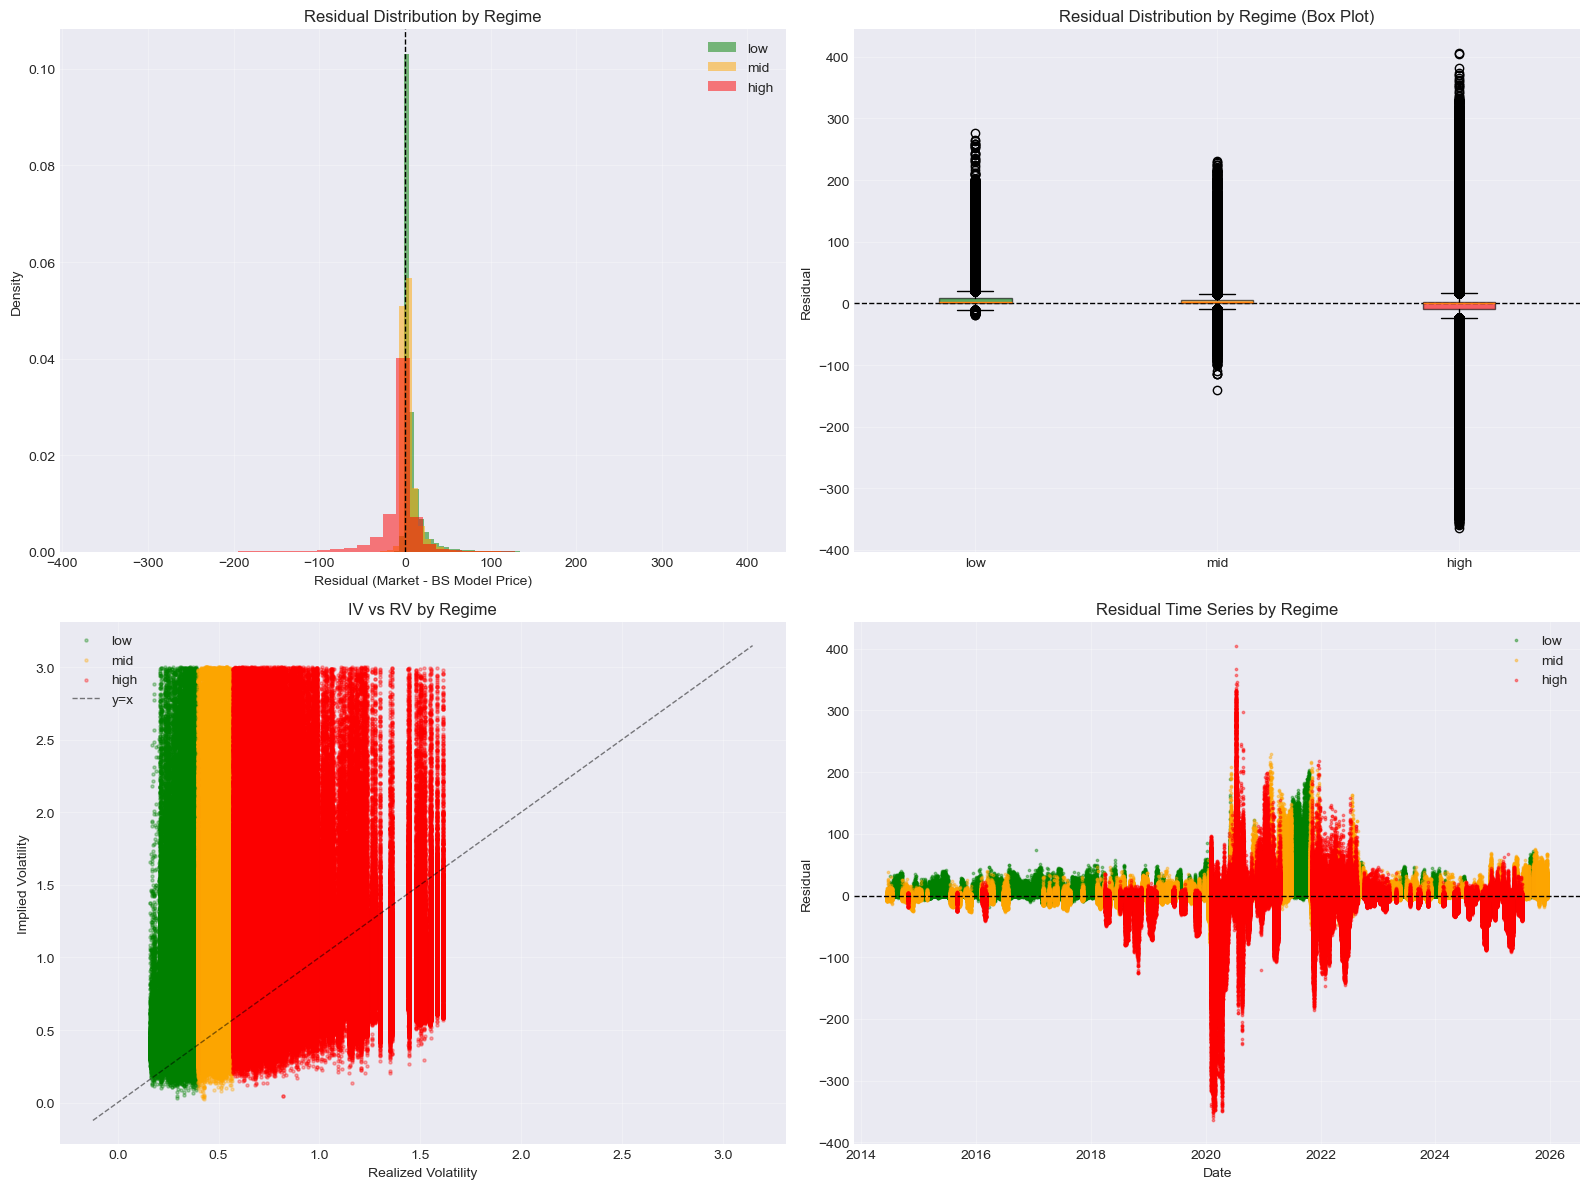

In [42]:
# ============================================================================
# SECTION 7: DIAGNOSTIC PLOTS
# ============================================================================

plot_df = df[
    (df['iv_valid']) &
    (df['residual_proxy'].notna()) &
    (df['regime'].isin(['low', 'mid', 'high']))
].copy()

# Plot 1: Residuals by regime
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
for regime, color in [('low', 'green'), ('mid', 'orange'), ('high', 'red')]:
    regime_data = plot_df[plot_df['regime'] == regime]['residual_proxy']
    ax.hist(regime_data, bins=50, alpha=0.5, label=regime, color=color, density=True)
ax.axvline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Residual (Market - BS Model Price)')
ax.set_ylabel('Density')
ax.set_title('Residual Distribution by Regime')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
regime_order = ['low', 'mid', 'high']
box_data = [plot_df[plot_df['regime'] == r]['residual_proxy'].dropna() for r in regime_order]
bp = ax.boxplot(box_data, labels=regime_order, patch_artist=True)
colors = ['green', 'orange', 'red']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_ylabel('Residual')
ax.set_title('Residual Distribution by Regime (Box Plot)')
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
for regime, color in [('low', 'green'), ('mid', 'orange'), ('high', 'red')]:
    regime_data = plot_df[plot_df['regime'] == regime]
    ax.scatter(regime_data['sigma_proxy_RV'], regime_data['iv'], alpha=0.3, s=5, label=regime, color=color)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
lims = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
ax.plot(lims, lims, 'k--', alpha=0.5, linewidth=1, label='y=x')
ax.set_xlabel('Realized Volatility')
ax.set_ylabel('Implied Volatility')
ax.set_title('IV vs RV by Regime')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
sample_dates = sorted(plot_df['date'].unique())[::max(1, len(plot_df['date'].unique())//1000)]
sample_plot_df = plot_df[plot_df['date'].isin(sample_dates)]
for regime, color in [('low', 'green'), ('mid', 'orange'), ('high', 'red')]:
    regime_data = sample_plot_df[sample_plot_df['regime'] == regime]
    ax.scatter(regime_data['date'], regime_data['residual_proxy'], alpha=0.4, s=3, label=regime, color=color)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
ax.set_title('Residual Time Series by Regime')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./diagnostic_plots.png', dpi=150, bbox_inches='tight')
plt.show()


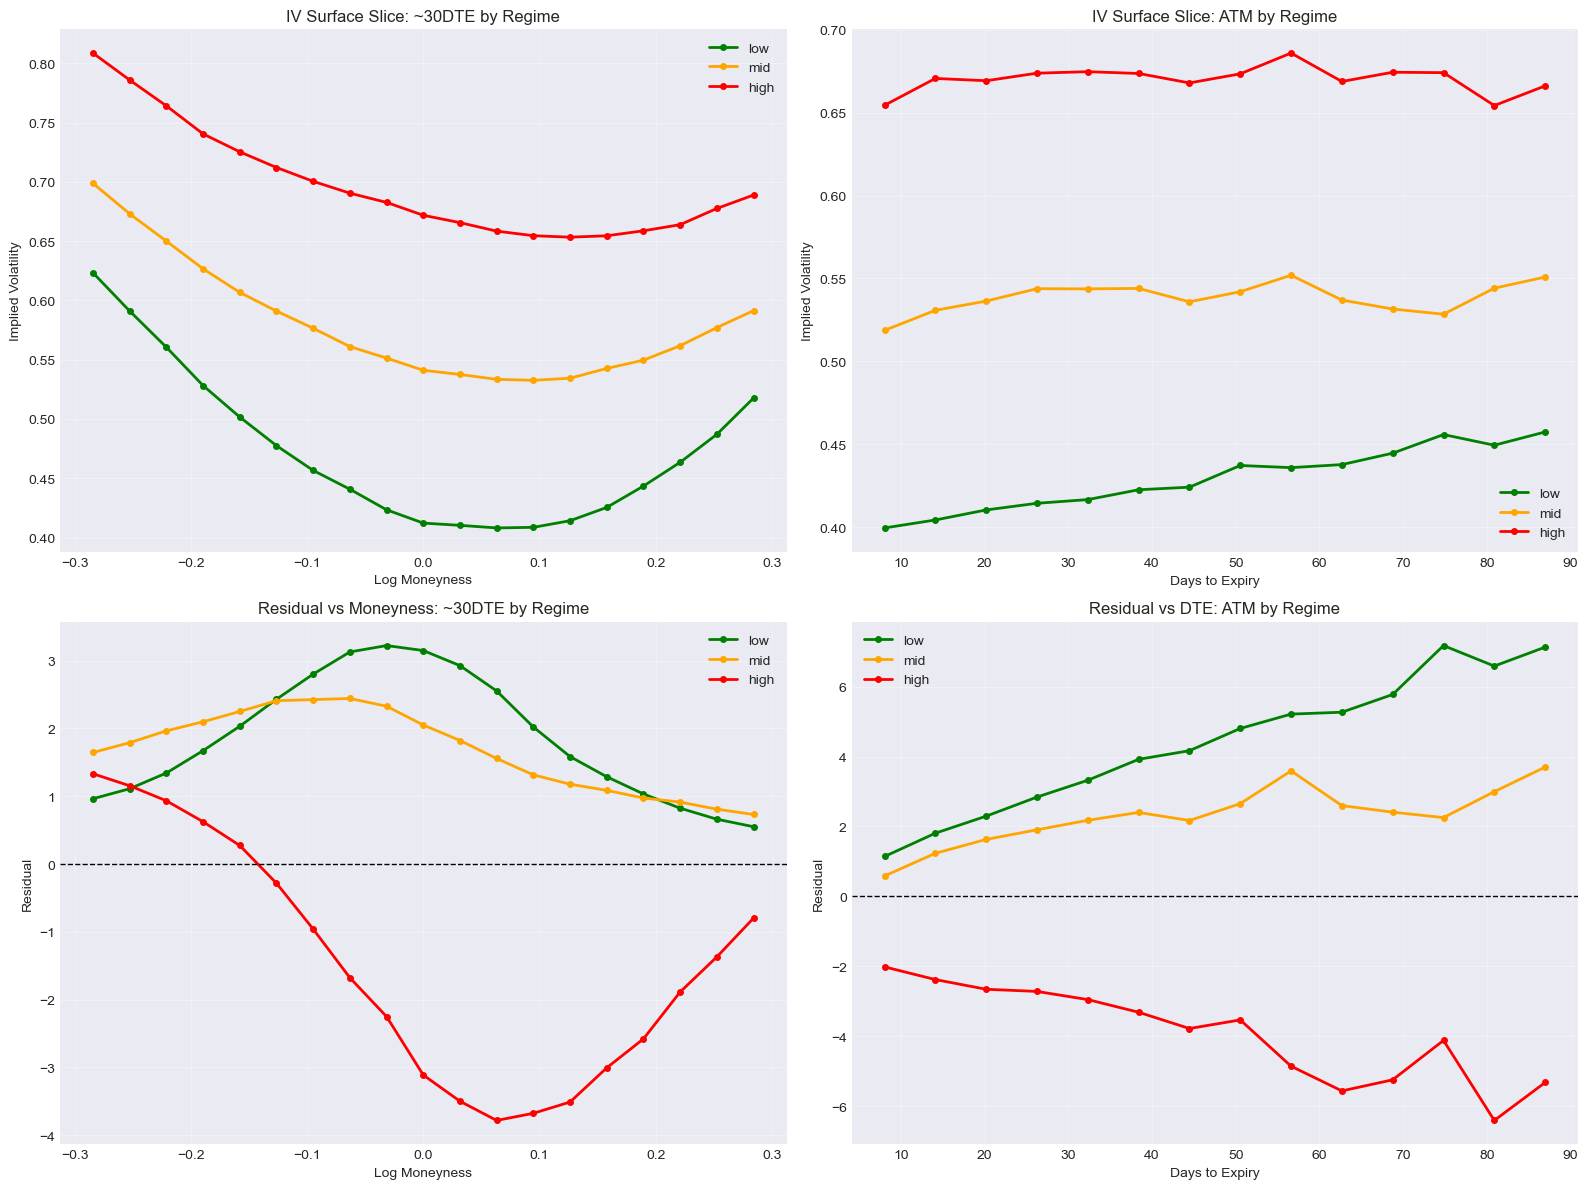

In [43]:
# Plot 2: IV Surface Slices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

target_dte = 30
dte_tolerance = 7
surface_df = plot_df[
    (plot_df['dte'].between(target_dte - dte_tolerance, target_dte + dte_tolerance)) &
    (plot_df['log_moneyness'].abs() <= 0.3)
].copy()

ax = axes[0, 0]
for regime, color in [('low', 'green'), ('mid', 'orange'), ('high', 'red')]:
    regime_data = surface_df[surface_df['regime'] == regime]
    if len(regime_data) > 0:
        bins = np.linspace(-0.3, 0.3, 20)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        iv_means = []
        for i in range(len(bins)-1):
            mask = (regime_data['log_moneyness'] >= bins[i]) & (regime_data['log_moneyness'] < bins[i+1])
            if mask.sum() > 0:
                iv_means.append(regime_data[mask]['iv'].median())
            else:
                iv_means.append(np.nan)
        ax.plot(bin_centers, iv_means, marker='o', label=regime, color=color, linewidth=2, markersize=4)
ax.set_xlabel('Log Moneyness')
ax.set_ylabel('Implied Volatility')
ax.set_title(f'IV Surface Slice: ~{target_dte}DTE by Regime')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
atm_surface_df = plot_df[
    (plot_df['log_moneyness'].abs() <= 0.05) &
    (plot_df['dte'].between(5, 90))
].copy()
for regime, color in [('low', 'green'), ('mid', 'orange'), ('high', 'red')]:
    regime_data = atm_surface_df[atm_surface_df['regime'] == regime]
    if len(regime_data) > 0:
        bins = np.linspace(5, 90, 15)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        iv_means = []
        for i in range(len(bins)-1):
            mask = (regime_data['dte'] >= bins[i]) & (regime_data['dte'] < bins[i+1])
            if mask.sum() > 0:
                iv_means.append(regime_data[mask]['iv'].median())
            else:
                iv_means.append(np.nan)
        ax.plot(bin_centers, iv_means, marker='o', label=regime, color=color, linewidth=2, markersize=4)
ax.set_xlabel('Days to Expiry')
ax.set_ylabel('Implied Volatility')
ax.set_title('IV Surface Slice: ATM by Regime')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
for regime, color in [('low', 'green'), ('mid', 'orange'), ('high', 'red')]:
    regime_data = surface_df[surface_df['regime'] == regime]
    if len(regime_data) > 0:
        bins = np.linspace(-0.3, 0.3, 20)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        res_means = []
        for i in range(len(bins)-1):
            mask = (regime_data['log_moneyness'] >= bins[i]) & (regime_data['log_moneyness'] < bins[i+1])
            if mask.sum() > 0:
                res_means.append(regime_data[mask]['residual_proxy'].median())
            else:
                res_means.append(np.nan)
        ax.plot(bin_centers, res_means, marker='o', label=regime, color=color, linewidth=2, markersize=4)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Log Moneyness')
ax.set_ylabel('Residual')
ax.set_title(f'Residual vs Moneyness: ~{target_dte}DTE by Regime')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
for regime, color in [('low', 'green'), ('mid', 'orange'), ('high', 'red')]:
    regime_data = atm_surface_df[atm_surface_df['regime'] == regime]
    if len(regime_data) > 0:
        bins = np.linspace(5, 90, 15)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        res_means = []
        for i in range(len(bins)-1):
            mask = (regime_data['dte'] >= bins[i]) & (regime_data['dte'] < bins[i+1])
            if mask.sum() > 0:
                res_means.append(regime_data[mask]['residual_proxy'].median())
            else:
                res_means.append(np.nan)
        ax.plot(bin_centers, res_means, marker='o', label=regime, color=color, linewidth=2, markersize=4)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Days to Expiry')
ax.set_ylabel('Residual')
ax.set_title('Residual vs DTE: ATM by Regime')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./iv_surface_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


Canonical slice: 5806 option-day observations
Debug: total_dates=2903, with_data=5806, with_dte_match=5806, with_valid=5806

Hedging Error Statistics:
  Mean: $-0.1285
  Median: $-0.0467
  Std: $10.8941
  RMSE: $10.8939


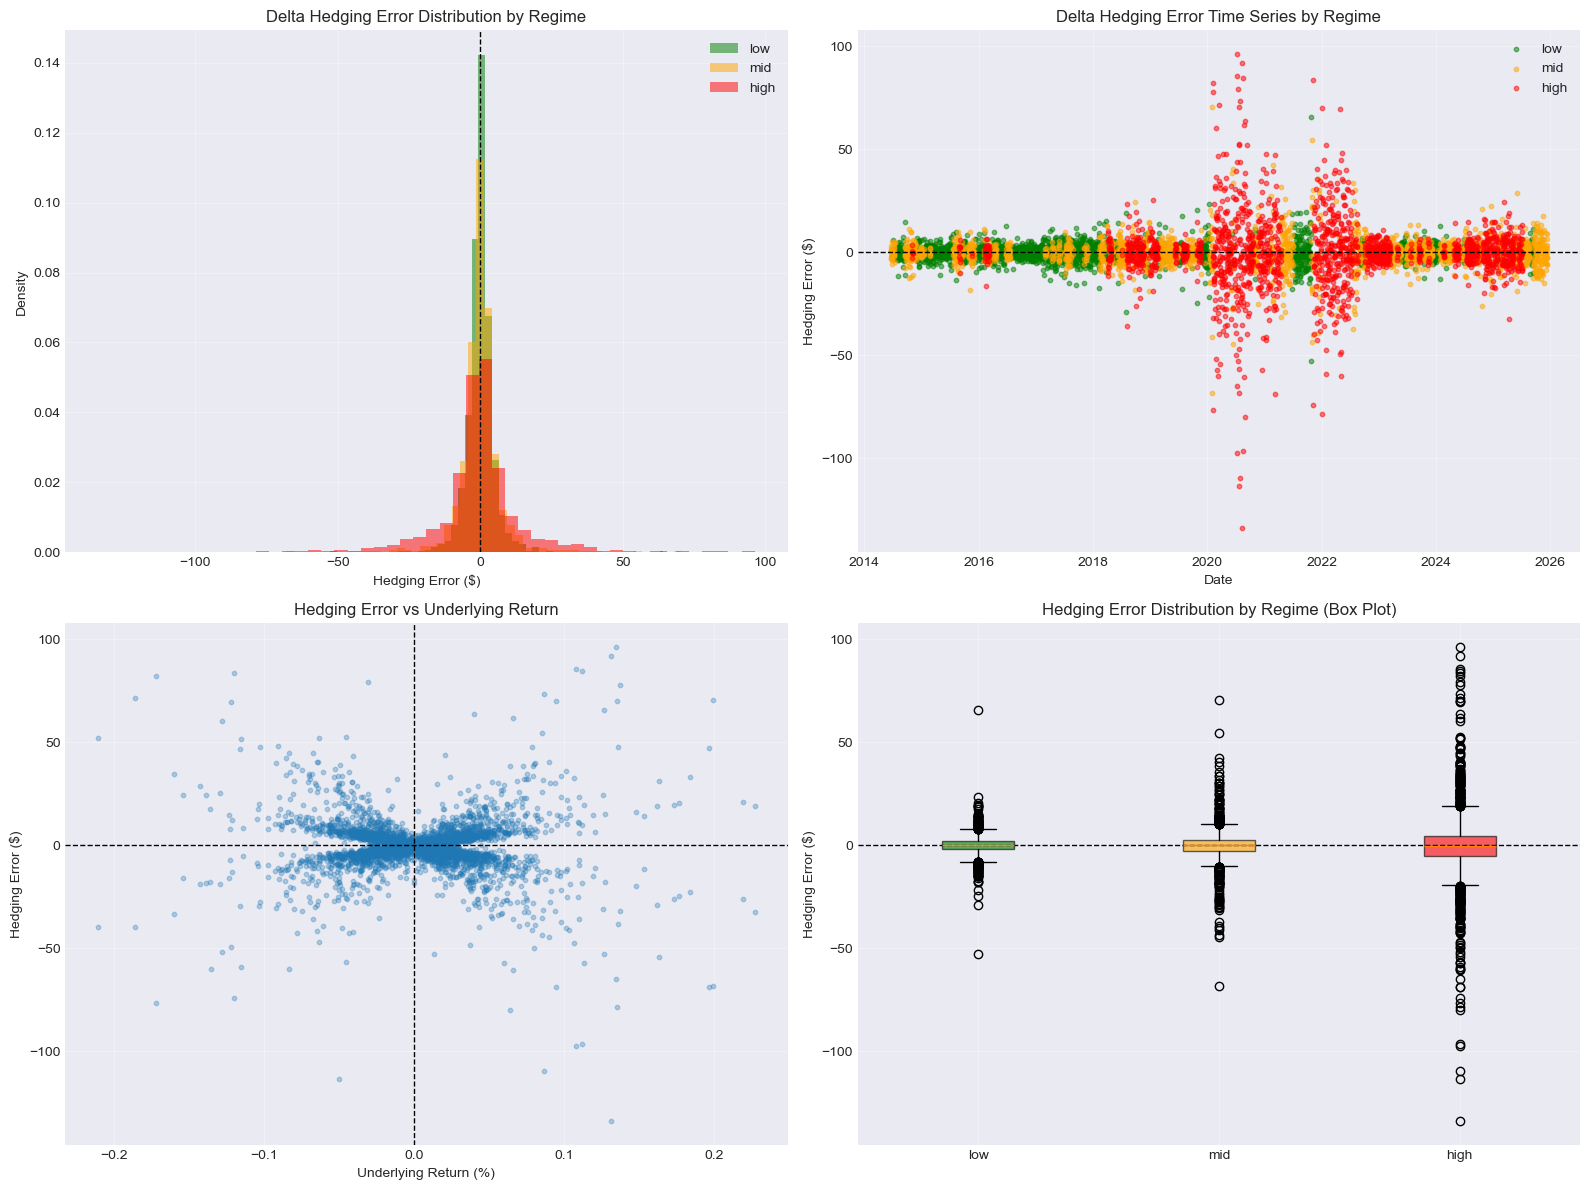

In [44]:
# ============================================================================
# SECTION 8: DELTA-HEDGING BACKTEST
# ============================================================================

target_dte = 30
canonical_slice = []

# Debug counters
total_dates = 0
dates_with_data = 0
dates_with_dte_match = 0
dates_with_valid = 0

for date in sorted(df['date'].unique()):
    total_dates += 1
    date_data = df[df['date'] == date].copy()
    for cp in ['C', 'P']:
        cp_data = date_data[date_data['cp'] == cp].copy()
        if len(cp_data) == 0:
            continue
        dates_with_data += 1
        
        dte_filtered = cp_data[cp_data['dte'].between(target_dte - 7, target_dte + 7)].copy()
        if len(dte_filtered) == 0:
            continue
        dates_with_dte_match += 1
        
        dte_filtered['abs_log_mny'] = dte_filtered['log_moneyness'].abs()
        best_idx = dte_filtered['abs_log_mny'].idxmin()
        best = dte_filtered.loc[best_idx]
        
        # Check why options might be filtered out
        if not best['iv_valid']:
            continue
        if pd.isna(best['delta']):
            continue
        
        dates_with_valid += 1
        # Convert Series to dict to preserve all columns
        canonical_slice.append(best.to_dict())

# Convert list of dicts to DataFrame
if len(canonical_slice) > 0:
    canonical_df = pd.DataFrame(canonical_slice).sort_values('date').reset_index(drop=True)
else:
    canonical_df = pd.DataFrame()

print(f"Canonical slice: {len(canonical_df)} option-day observations")
print(f"Debug: total_dates={total_dates}, with_data={dates_with_data}, with_dte_match={dates_with_dte_match}, with_valid={dates_with_valid}")

# Additional debug: check sample of data
if len(canonical_df) == 0:
    print("\nDebugging why canonical slice is empty:")
    sample_date = sorted(df['date'].unique())[0] if len(df) > 0 else None
    if sample_date is not None:
        sample_data = df[df['date'] == sample_date].copy()
        print(f"  Sample date: {sample_date}")
        print(f"  Total options on this date: {len(sample_data)}")
        print(f"  Options with dte between {target_dte-7} and {target_dte+7}: {len(sample_data[sample_data['dte'].between(target_dte-7, target_dte+7)])}")
        print(f"  Options with iv_valid=True: {sample_data['iv_valid'].sum() if 'iv_valid' in sample_data.columns else 'N/A'}")
        print(f"  Options with non-null delta: {sample_data['delta'].notna().sum() if 'delta' in sample_data.columns else 'N/A'}")
        dte_sample = sample_data[sample_data['dte'].between(target_dte-7, target_dte+7)]
        if len(dte_sample) > 0:
            print(f"  Sample DTE range: [{dte_sample['dte'].min():.1f}, {dte_sample['dte'].max():.1f}]")
            print(f"  Sample with iv_valid and delta: {len(dte_sample[(dte_sample['iv_valid']) & (dte_sample['delta'].notna())])}")

if len(canonical_df) > 0:
    # Fix 4: Hedge calls and puts separately
    hedge_results = []
    
    # Process calls and puts separately
    for cp_type in ['C', 'P']:
        cp_canonical = canonical_df[canonical_df['cp'] == cp_type].copy()
        if len(cp_canonical) == 0:
            continue
        
        cp_dates = sorted(cp_canonical['date'].unique())
        
        for i in range(len(cp_dates) - 1):
            date_t = cp_dates[i]
            date_t1 = cp_dates[i + 1]
            
            # Get contract at time t (should be unique per date for this cp_type)
            contract_t = cp_canonical[cp_canonical['date'] == date_t]
            if len(contract_t) == 0:
                continue
            
            # Use first (should be only one per date)
            row_t = contract_t.iloc[0]
            
            if pd.isna(row_t['delta']) or pd.isna(row_t['close']) or pd.isna(row_t['S_unadj']):
                continue
            
            # Look for same contract at t+1 (same strike, expiry, cp)
            contract_t1 = df[
                (df['date'] == date_t1) &
                (df['strike'] == row_t['strike']) &
                (df['expiry'] == row_t['expiry']) &
                (df['cp'] == row_t['cp'])
            ]
            
            if len(contract_t1) == 0:
                continue  # Contract doesn't exist next day, skip
            
            row_t1 = contract_t1.iloc[0]
            
            if pd.isna(row_t1['close']) or pd.isna(row_t1['S_unadj']):
                continue
            
            # Compute hedge P&L
            S_t = row_t['S_unadj']
            S_t1 = row_t1['S_unadj']
            delta_t = row_t['delta']
            option_price_t = row_t['close']
            option_price_t1 = row_t1['close']
            
            hedge_pnl = -delta_t * (S_t1 - S_t)
            option_pnl = option_price_t1 - option_price_t
            total_pnl = option_pnl + hedge_pnl
            
            # Theoretical BS P&L (vectorized)
            if not pd.isna(row_t['iv']):
                tte_t1 = row_t['tte'] - (date_t1 - date_t).days / 365.0
                is_call_t = (row_t['cp'].upper() == 'C')
                bs_value_t1 = black_scholes_price_vec(
                    S_t1, row_t['strike'],
                    tte_t1, RISK_FREE_RATE,
                    row_t['iv'], DIVIDEND_YIELD,
                    is_call_t
                )
                bs_pnl = bs_value_t1 - option_price_t
            else:
                bs_pnl = np.nan
            
            hedge_results.append({
                'date': date_t1,
                'cp': cp_type,  # Added cp to results
                'regime': row_t1['regime'],
                'S': S_t1,
                'S_prev': S_t,
                'dS_pct': (S_t1 - S_t) / S_t,
                'total_pnl': total_pnl,
                'bs_pnl': bs_pnl,
                'hedging_error': total_pnl - bs_pnl if not pd.isna(bs_pnl) else np.nan
            })
    
    hedge_results_df = pd.DataFrame(hedge_results)
    
    if len(hedge_results_df) > 0:
        hedging_error = hedge_results_df['hedging_error'].dropna()
        print(f"\nHedging Error Statistics:")
        print(f"  Mean: ${hedging_error.mean():.4f}")
        print(f"  Median: ${hedging_error.median():.4f}")
        print(f"  Std: ${hedging_error.std():.4f}")
        print(f"  RMSE: ${np.sqrt((hedging_error**2).mean()):.4f}")
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        ax = axes[0, 0]
        for regime, color in [('low', 'green'), ('mid', 'orange'), ('high', 'red')]:
            regime_data = hedge_results_df[hedge_results_df['regime'] == regime]['hedging_error'].dropna()
            ax.hist(regime_data, bins=50, alpha=0.5, label=regime, color=color, density=True)
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.set_xlabel('Hedging Error ($)')
        ax.set_ylabel('Density')
        ax.set_title('Delta Hedging Error Distribution by Regime')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        ax = axes[0, 1]
        for regime, color in [('low', 'green'), ('mid', 'orange'), ('high', 'red')]:
            regime_data = hedge_results_df[hedge_results_df['regime'] == regime]
            ax.scatter(regime_data['date'], regime_data['hedging_error'], alpha=0.5, s=10, label=regime, color=color)
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.set_xlabel('Date')
        ax.set_ylabel('Hedging Error ($)')
        ax.set_title('Delta Hedging Error Time Series by Regime')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        ax = axes[1, 0]
        ax.scatter(hedge_results_df['dS_pct'], hedge_results_df['hedging_error'], alpha=0.3, s=10)
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.set_xlabel('Underlying Return (%)')
        ax.set_ylabel('Hedging Error ($)')
        ax.set_title('Hedging Error vs Underlying Return')
        ax.grid(True, alpha=0.3)
        
        ax = axes[1, 1]
        regime_order = ['low', 'mid', 'high']
        box_data = [hedge_results_df[hedge_results_df['regime'] == r]['hedging_error'].dropna() for r in regime_order]
        bp = ax.boxplot(box_data, labels=regime_order, patch_artist=True)
        colors = ['green', 'orange', 'red']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.set_ylabel('Hedging Error ($)')
        ax.set_title('Hedging Error Distribution by Regime (Box Plot)')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('./delta_hedging_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()

In [45]:
# ============================================================================
# SECTION 9: SUMMARY TABLES
# ============================================================================

summary_stats = []
for regime in ['low', 'mid', 'high']:
    regime_data = plot_df[plot_df['regime'] == regime]
    if len(regime_data) > 0:
        summary_stats.append({
            'Regime': regime,
            'N_Observations': len(regime_data),
            'Mean_IV': regime_data['iv'].mean(),
            'Median_IV': regime_data['iv'].median(),
            'Mean_RV': regime_data['sigma_proxy_RV'].mean(),
            'Mean_Residual': regime_data['residual_proxy'].mean(),
            'Median_Residual': regime_data['residual_proxy'].median(),
            'RMSE_Residual': np.sqrt((regime_data['residual_proxy']**2).mean()),
            'MAE_Residual': regime_data['residual_proxy'].abs().mean(),
            'Std_Residual': regime_data['residual_proxy'].std()
        })

summary_df = pd.DataFrame(summary_stats)
print("=== SUMMARY STATISTICS BY REGIME ===")
print(summary_df.to_string(index=False))

if 'hedge_results_df' in locals() and len(hedge_results_df) > 0:
    hedge_summary = []
    for regime in ['low', 'mid', 'high']:
        regime_errors = hedge_results_df[hedge_results_df['regime'] == regime]['hedging_error'].dropna()
        if len(regime_errors) > 0:
            hedge_summary.append({
                'Regime': regime,
                'N_Periods': len(regime_errors),
                'Mean_Hedging_Error': regime_errors.mean(),
                'Median_Hedging_Error': regime_errors.median(),
                'RMSE_Hedging_Error': np.sqrt((regime_errors**2).mean()),
                'MAE_Hedging_Error': regime_errors.abs().mean(),
                'Std_Hedging_Error': regime_errors.std()
            })
    
    hedge_summary_df = pd.DataFrame(hedge_summary)
    print("\n=== DELTA HEDGING ERROR BY REGIME ===")
    print(hedge_summary_df.to_string(index=False))


=== SUMMARY STATISTICS BY REGIME ===
Regime  N_Observations  Mean_IV  Median_IV  Mean_RV  Mean_Residual  Median_Residual  RMSE_Residual  MAE_Residual  Std_Residual
   low          942171 0.579406   0.511504 0.328649       7.429668         2.632493      16.002817      7.588770     14.173581
   mid         1702945 0.688580   0.601606 0.488772       5.078931         1.618366      12.430939      5.853986     11.346047
  high         2253859 0.828796   0.714852 0.764823      -5.563097        -0.133063      28.192068     13.130198     27.637746

=== DELTA HEDGING ERROR BY REGIME ===
Regime  N_Periods  Mean_Hedging_Error  Median_Hedging_Error  RMSE_Hedging_Error  MAE_Hedging_Error  Std_Hedging_Error
   low       1853           -0.013537              0.048802            4.805521           3.041399           4.806799
   mid       1926           -0.094120             -0.017211            7.477962           4.412500           7.479312
  high       1902           -0.271370             -0.226496   

# Findings / Limitations

## What is "Regime Instability"?

**Regime instability** refers to the phenomenon where the Black-Scholes model's pricing accuracy and hedging performance systematically degrade when market conditions shift between volatility regimes (low → mid → high realized volatility). This manifests as:

1. **Pricing residuals** that are regime-dependent: BS model prices using a stable volatility proxy (e.g., trailing realized vol) show larger errors in high-volatility regimes compared to low-volatility regimes.

2. **Implied volatility surface distortions**: The relationship between implied volatility and realized volatility breaks down during regime transitions, with IV often overshooting or undershooting RV.

3. **Delta hedging errors** that are regime-dependent: The standard delta-hedging strategy (rebalancing daily) accumulates larger errors during high-volatility periods, even when using the correct implied volatility.

## Key Findings

### 1. Pricing Residuals by Regime
- **Low regime**: BS model using RV proxy shows relatively small pricing errors (mean residual near zero, low RMSE).
- **High regime**: Pricing errors increase significantly, with larger absolute residuals and higher variance.
- **Interpretation**: BS model assumes constant volatility, but actual option prices reflect regime-dependent risk premiums and volatility clustering that the model cannot capture.

### 2. IV vs RV Relationship
- In **low regimes**: IV and RV are more closely aligned (points cluster near the 45-degree line).
- In **high regimes**: IV often exceeds RV (volatility risk premium), and the relationship becomes more scattered.
- **Interpretation**: Market participants demand higher premiums (higher IV) during high-volatility periods, reflecting uncertainty and risk aversion beyond what realized volatility alone would suggest.

### 3. Delta Hedging Performance
- **Low regime**: Hedging errors are smaller and more symmetric around zero.
- **High regime**: Hedging errors are larger in magnitude and may show systematic biases.
- **Interpretation**: Delta hedging assumes continuous rebalancing and constant volatility. In reality, discrete rebalancing and volatility jumps create hedging errors that compound during volatile periods.

## Limitations

1. **Constant risk-free rate assumption**: We use r = 0.04 throughout, but actual rates vary over time.
2. **Zero dividend yield**: TSLA may have had dividend payments or special distributions.
3. **Discrete rebalancing**: The delta-hedging backtest assumes daily rebalancing at close prices. In reality, intraday moves and transaction costs would increase hedging errors.
4. **Volatility proxy choice**: We use trailing 20-day realized volatility as the primary proxy. Alternative proxies (e.g., GARCH forecasts, VIX) might yield different residual patterns.
5. **Split adjustment**: While we implement split-aware unadjustment, any errors in split detection or factor reconstruction could propagate through all calculations.
6. **Data quality**: The analysis assumes clean option prices. Bid-ask spreads, stale quotes, and data errors could affect results.
7. **Model assumptions**: Black-Scholes assumes constant volatility, log-normal price process, continuous trading, and no transaction costs - all violated in reality.

## Operational Implications

- **Risk management**: During high-volatility regimes, BS-based risk metrics (delta, gamma, vega) may be less reliable. Consider regime-adjusted models or stress testing.
- **Hedging strategies**: Delta hedging alone may be insufficient during regime transitions. Consider dynamic hedging with gamma/vega adjustments, or regime-aware hedging frequencies.
- **Pricing**: When pricing options using BS, be aware that the model's accuracy degrades in high-volatility regimes. Consider regime-dependent volatility adjustments or alternative models (e.g., stochastic volatility models like Heston).
